In [9]:
import pandas as pd 
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.nn.functional as F
import math
from scipy.linalg import svd
from torch.utils.data import Dataset, DataLoader
from numpy import linalg as LA
from time import perf_counter 
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

dfP = pd.read_csv("deseason.csv") 
### "Data preprocessing
df = np.array(dfP)[0:301,0:50]
### "Data preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [10]:
p = 30
N = 50
Smp_size = 300-p

In [11]:
### "Generate Linear Time Series Inputs and Targetted Output
# return large transition Matrix A
def kronecker(A, B):
    return torch.ger(A.view(-1), B.view(-1)).reshape(*(A.size() + B.size())).permute([0, 2, 1, 3]).reshape(A.size(0)*B.size(0),A.size(1)*B.size(1))

### " F-norm of A
class L2LossFun(nn.Module):
    
    def __init__(self):
        super(L2LossFun, self).__init__()
    def forward(self, A_Est, A_True):
        gap = math.sqrt(torch.sum((A_Est - A_True)**2))
        return gap

class genA_true:
    
    def genA(r1, r2, r3, p, N):
        
        def genU(x, y, r, trans):
            # x, y-stands for the size of the random matrix
            # r stands for the numbers of dimensions to keep
            # trans is a bool to judge whether to transpose or not
            URM = torch.randn(x, y)
            U, s, VT = svd(URM)
            if trans == True:
                Us = torch.tensor(np.transpose(U[:,:r]))
            else:
                Us = torch.tensor(U[:,:r])
            return Us

        G1 =  F.normalize(torch.randn(r1, r2*r3), p=2, dim=0)*0.9 # norm of G is fixed to be 0.95 -> l2 operator norm
        #G1 =  (F.normalize(torch.randn(r1*r2*r3), p=2, dim=0)*0.95).view(r1, r2*r3) # norm of G is fixed to be 0.95 -> Frobenius norm
        U1 = genU(N, N, r1, False)
        U2T = genU(N, N, r2, True)
        U3T = genU(p, p, r3, True)
        A_dim1 = torch.mm(torch.mm(U1, G1), kronecker(U3T,U2T))
        A_dim2 = torch.eye(N*p)[:N*(p-1),:]
        A = torch.cat((A_dim1, A_dim2), dim=0)
        return A
    
def rearrangeG(K):
    K = K.permute(1,0)
    i = j = 0
    for j in range(r3):
            for i in range(r2):
                if i == 0 and j == 0:
                    tmp = K[:1,:]
                else:
                    tmp = torch.cat([tmp, K[(r3*i+j):(r3*i+1+j),:]], dim = 0)   
    tmp = tmp.permute(1,0)
    return(tmp)

def Param_Matrix(net, p, N):
    
    U2T = torch.squeeze(net.conv1.weight).view(r2, N)
    U3T = torch.squeeze(net.conv2.weight).view(r3, p)
    G1 = rearrangeG(net.fc1.weight)
    U1 = net.fc2.weight
    A = torch.mm(torch.mm(U1, G1), kronecker(U3T,U2T))
    return A

def Param_MatrixR(net):

    A = torch.mm(net.fc2.weight,net.fc1.weight)
    return A

In [12]:
### "We can use our method to generate RandomDataset
# For our linear settings burnt in is needed
class RealDataset(Dataset):
    
    def __init__(self, p, N, Smp_size, df):
        self.X = []
        self.y = []
        for i in range(Smp_size):
            if i == 0:
                input_TS = torch.tensor(df[ [29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0] , : ]).permute(1,0).view(1,1,N,p) #change according to p
                self.X.append(torch.squeeze(input_TS.view(1,1,N,p), dim = 0))
                output_TS = torch.squeeze(torch.tensor(df[ p:(p+1) , : ]).permute(1,0).view(1,1,N,1))
                self.y.append(output_TS[:N])  
            else:
                input_TS = torch.cat([self.y[i-1].view(1,1,N,1), input_TS], dim = 3)
                self.X.append(torch.squeeze(input_TS[:,:,:N,:p], dim = 0))
                out_tmp = torch.squeeze(torch.tensor(df[ (i+p):(i+p+1) , : ]).permute(1,0).view(1,1,N,1))
                self.y.append(out_tmp[:N])
                
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

In [13]:
### "" LS method
distance = L2LossFun()
criterion = nn.MSELoss()
    
dsT = RealDataset(p=p, N=N, Smp_size=Smp_size, df=df[:300,])
dsF = RealDataset(p=p, N=N, Smp_size=Smp_size, df=df[1:301,])
X_F,y_F = dsF[Smp_size-1]
X_F = X_F.view(1,1,N,p)
ds = DataLoader(dsT, batch_size=Smp_size, shuffle=False)
    
for ix, (_x, _y) in enumerate(ds):
        
    X = _x.permute(0, 1, 3, 2).reshape(Smp_size, 1, p*N)
    X = torch.squeeze(X.permute(1, 0, 2))
    X_T = torch.transpose(X, 0, 1)
    XTX = torch.mm(X_T, X)
    XTX_Inv = torch.inverse(XTX)
    Y = _y
    A_EstLS = torch.mm(XTX_Inv, torch.mm(X_T, Y))
    Yhat = torch.mm(X, A_EstLS)
    lossLS = criterion(Y, Yhat)

X_F = Variable(X_F).float()
y_F = torch.tensor(Variable(y_F).float())
y_predLS = torch.squeeze(torch.mm(torch.tensor(X_F).view(1,N*p), A_EstLS.float()))
predErrorLS = distance(y_predLS, y_F)
print("PredError for LS is {}.".format(predErrorLS))
print(A_EstLS)


PredError for LS is 10926.814357350453.
tensor([[-92.0000,  76.0000,  -8.0000,  ...,  44.0000,  40.0000,  32.0000],
        [ 24.5000,  -3.5000,  15.5000,  ...,  13.0000,  -7.0000,  12.5000],
        [  4.0000, -14.0000, -11.0000,  ...,  -9.0000, -28.0000, -26.0000],
        ...,
        [ -1.5000, -12.5000,  -2.0000,  ...,   2.5000, -10.5000,  -6.0000],
        [ -9.5000,   9.0000,  -0.5000,  ...,  -5.5000,  17.5000,   5.5000],
        [-58.0000,  24.0000, -14.0000,  ..., -40.0000,  28.0000,  -2.0000]],
       dtype=torch.float64)


/Users/amy/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/amy/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [14]:
U, s, VT = svd(A_EstLS)

[10886.4037821   8061.25360648  1222.99894216  1022.14804481
   989.9253821    954.58002252   945.95928318   921.06797778
   896.11114436   882.52885849   871.80965375   857.61746807
   849.05482625   830.12211729   823.00052646   816.36369916
   798.39697063   793.35025422   785.16270301   767.9115743
   757.20096677   754.19452151   752.2641915    735.37616728
   726.95986884   721.33801042   716.79184652   705.72325401
   700.33891853   694.10704728   689.13152586   681.3350794
   658.28019324   653.51172377   644.2080339    636.39298839
   627.39051476   619.47233278   615.37040411   604.02296123
   594.28879936   591.1630555    576.26438928   573.63928171
   550.2481103    537.62861203   521.76614076   503.01611024
   489.18895742   415.7811506 ]


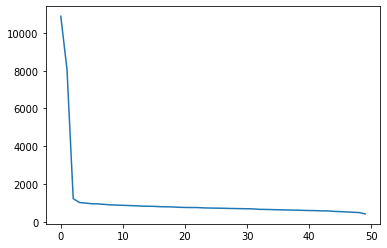

In [15]:
print(s)
plt.plot(s)

In [16]:
A = A_EstLS.reshape(p,N,N)

In [17]:
A2 = A.permute(0,2,1).reshape(-1,N)
A3 = A.permute(1,2,0).reshape(-1,p)
U2, s2, VT2 = svd(A2)
U3, s3, VT3 = svd(A3)

[4255.24141453 4093.54478363 3751.10625349 3317.24575694 3148.87611127
 2985.30042538 2951.48190753 2808.87636798 2806.19699692 2678.07234767
 2641.05904235 2507.74888429 2495.65457801 2399.6628868  2303.54822824
 2222.67554399 2192.78153126 2055.34758505 2017.97760791 1998.13333325
 1928.10352496 1799.37601208 1770.89623614 1731.89714427 1641.35391179
 1569.85761907 1542.27872618 1465.1892733  1407.2768075  1391.75673112
 1375.79677679 1331.98764804 1304.42533978 1271.94319163 1226.13021923
 1215.53668439 1115.50239323 1064.45265975 1009.11141716  977.74259116
  946.55157057  897.18293367  857.8645149   839.990732    804.51341665
  766.45626591  750.27507738  708.49258393  676.31984079  610.0429444 ]
[4495.94817557 4125.32855926 3731.67921379 3481.46774552 3404.68553076
 3293.06483799 3225.35830005 3150.43469496 2923.27424385 2831.15462501
 2726.92483692 2690.33202712 2546.64712311 2499.73180385 2424.36279059
 2318.62802209 2243.68520952 2225.64135132 2182.69070121 2096.78266159
 1990

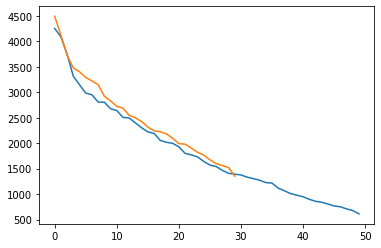

In [18]:
print(s2)
plt.plot(s2)
print(s3)
plt.plot(s3)